# SVMs para clasificación de cafés

Vamos a predecir la calidad "Total Cup Points" de cada café en función de su origen, procesamiento etc.

Se omiten las columnas correspondientes a características de calidad puesto que "Total Cup Points" es literalmente la suma de ellas:
- Aroma: Refers to the scent or fragrance of the coffee.
- Flavor: The flavor of coffee is evaluated based on the taste, including any sweetness, bitterness, acidity, and other flavor notes.
- Aftertaste: Refers to the lingering taste that remains in the mouth after swallowing the coffee.
- Acidity: Acidity in coffee refers to the brightness or liveliness of the taste.
- Body: The body of coffee refers to the thickness or viscosity of the coffee in the mouth.
- Balance: Balance refers to how well the different flavor components of the coffee work together.
- Uniformity: Uniformity refers to the consistency of the coffee from cup to cup.
- Clean Cup: A clean cup refers to a coffee that is free of any off-flavors or defects, such as sourness, mustiness, or staleness.
- Sweetness: It can be described as caramel-like, fruity, or floral, and is a desirable quality in coffee.

El puntaje es contínuo, asi que discretizamos en tres intervalos guiados por la distribución de los datos:
- <= 83: Gama Baja
- 83 - 85: Gama Media
- \>= 85: Gama Alta


### Downloading the Data


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fatihb/coffee-quality-data-cqi")

print("Path to dataset files:", path)

/home/ton/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 21.8k/21.8k [00:00<00:00, 19.5MB/s]

Extracting files...
Path to dataset files: /home/ton/.cache/kagglehub/datasets/fatihb/coffee-quality-data-cqi/versions/1


In [28]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import datasets, svm, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import random

import warnings; warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 8})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend',fontsize=10)

### Data Loading & Exploration (Tomas)



In [29]:
##if you run it twice you need to re-run the previous cell

df = pd.read_csv(f"{path}/df_arabica_clean.csv")
df.head()

,Unnamed: 0,ID,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,...,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Expiration,Certification Body,Certification Address,Certification Contact
0,0,0,Colombia,Finca El Paraiso,CQU2022015,Finca El Paraiso,NaN,Coffee Quality Union,1700-1930,"Piendamo,Cauca",...,89.33,11.8,0,0,green,3,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
1,1,1,Taiwan,Royal Bean Geisha Estate,"The 2022 Pacific Rim Coffee Summit,T037",Royal Bean Geisha Estate,NaN,Taiwan Coffee Laboratory,1200,Chiayi,...,87.58,10.5,0,0,blue-green,0,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
2,2,2,Laos,OKLAO coffee farms,"The 2022 Pacific Rim Coffee Summit,LA01",oklao coffee processing plant,NaN,Taiwan Coffee Laboratory,1300,Laos Borofen Plateau,...,87.42,10.4,0,0,yellowish,2,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
3,3,3,Costa Rica,La Cumbre,CQU2022017,La Montana Tarrazu MIll,NaN,Coffee Quality Union,1900,"Los Santos,Tarrazu",...,87.17,11.8,0,0,green,0,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
4,4,4,Colombia,Finca Santuario,CQU2023002,Finca Santuario,NaN,Coffee Quality Union,1850-2100,"Popayan,Cauca",...,87.08,11.6,0,2,yellow-green,2,"March 5th, 2024",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901


Eliminaremos las columnas de valores de calidad ya que trivializarian la predicción del target

In [ ]:
df = df.drop(["Aroma", "Flavor", "Aftertaste","Acidity","Body","Balance","Uniformity","Clean Cup","Sweetness"],axis=1)

Vemos distribución de target (calidad)

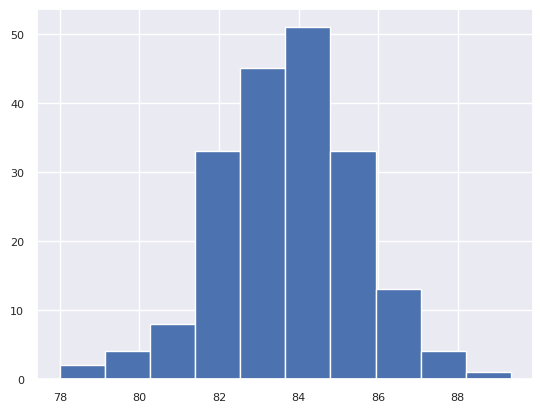

In [55]:
plt.hist(df["Total Cup Points"])
plt.show()

In [56]:
bajos = len(df[df["Total Cup Points"] <= 83])
mid = df[df["Total Cup Points"] < 85]
mid =  len(mid[mid["Total Cup Points"] > 83])
high = len(df[df["Total Cup Points"] >= 85])
print("Cantidad de valores bajos, medios y altos: ", bajos,mid,high)

Cantidad de valores bajos, medios y altos:  63 86 45


In [57]:

print(df.info()) #basic info of each variable

print("\nBasic Statistics of Each Variable\n")

print(df.describe()) #stats of each variable

print("ARE THERE MISSING VALUES?", df.isnull().values.any())#check whether any value is missing
print(df.isna().sum())#counts the number of missing values



<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 0 to 206
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             194 non-null    int64  
 1   ID                     194 non-null    int64  
 2   Country of Origin      194 non-null    object 
 3   Farm Name              194 non-null    object 
 4   Lot Number             194 non-null    object 
 5   Mill                   194 non-null    object 
 6   Company                194 non-null    object 
 7   Altitude               194 non-null    object 
 8   Region                 194 non-null    object 
 9   Producer               194 non-null    object 
 10  Number of Bags         194 non-null    int64  
 11  Bag Weight             194 non-null    object 
 12  In-Country Partner     194 non-null    object 
 13  Harvest Year           194 non-null    object 
 14  Grading Date           194 non-null    object 
 15  Owner      

Principalmente faltan valores de la columna ICO Number (>50%). La eliminaremos.

In [ ]:
df = df.drop(["ICO Number"],axis=1)

Eliminaremos también las filas con valores faltantes ya que muchas son categóricas y no se pueden imputar correctamente

In [50]:
df = df.dropna(axis=0)

Visualizamos la distribución de variables categoricas y numericas por separado

In [75]:
numerical_columns = df.select_dtypes(include='number').columns
categorical_columns = df.select_dtypes(include='object').columns
categorical_columns


Index(['Country of Origin', 'Farm Name', 'Lot Number', 'Mill', 'Company',
       'Altitude', 'Region', 'Producer', 'Bag Weight', 'In-Country Partner',
       'Harvest Year', 'Grading Date', 'Owner', 'Variety', 'Status',
       'Processing Method', 'Color', 'Expiration', 'Certification Body',
       'Certification Address', 'Certification Contact'],
      dtype='object')

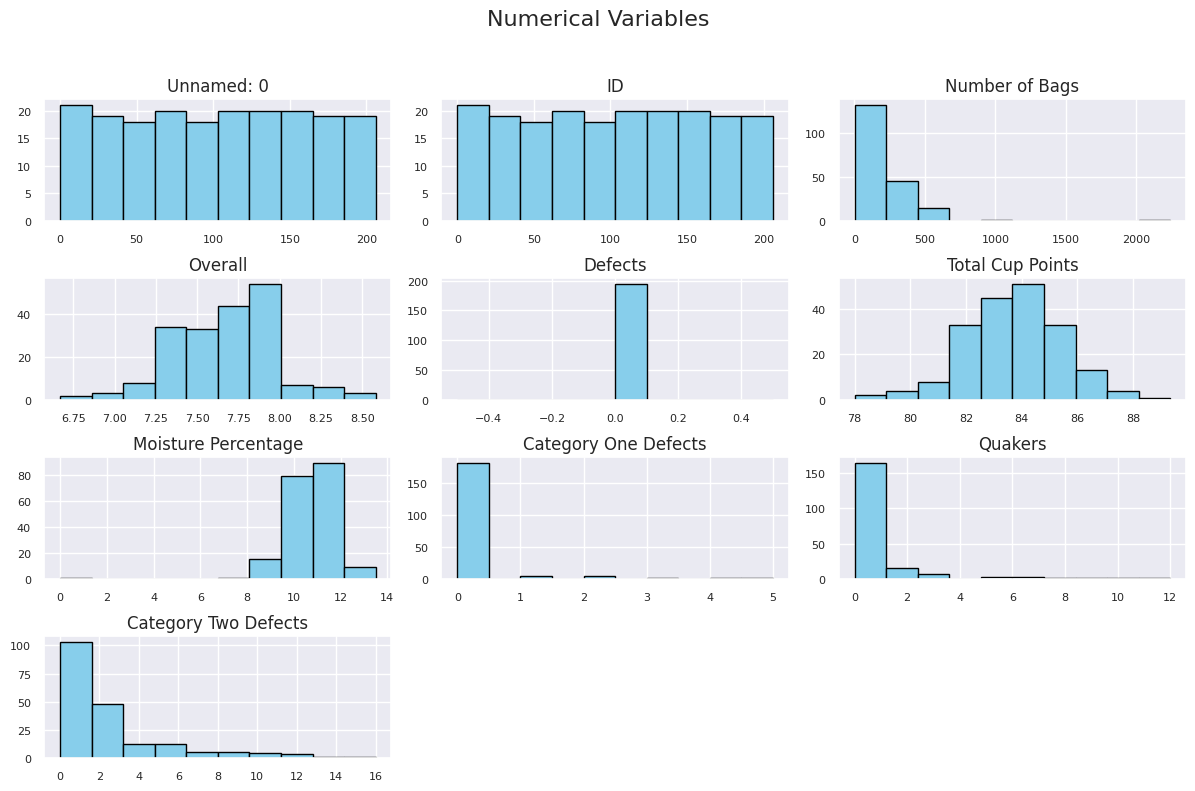

In [74]:

df_numeric = df[numerical_columns]

fig, ax = plt.subplots(4,3,figsize=(12,8))
fig.suptitle("Numerical Variables", fontsize=16)
ax = ax.flatten()

# Plot a histogram for each column
for i, col in enumerate(df_numeric.columns):
    ax[i].hist(df_numeric[col], bins=10, color='skyblue', edgecolor='black')
    ax[i].set_title(col)

# Hide any remaining empty subplots
for j in range(len(df_numeric.columns), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title
plt.show()

Se puede eliminar Defects ya que es constante, e ID y Unnamed:0 por ser variables índices.

In [89]:
df = df.drop(["Defects","Unnamed: 0", "ID"],axis=1)

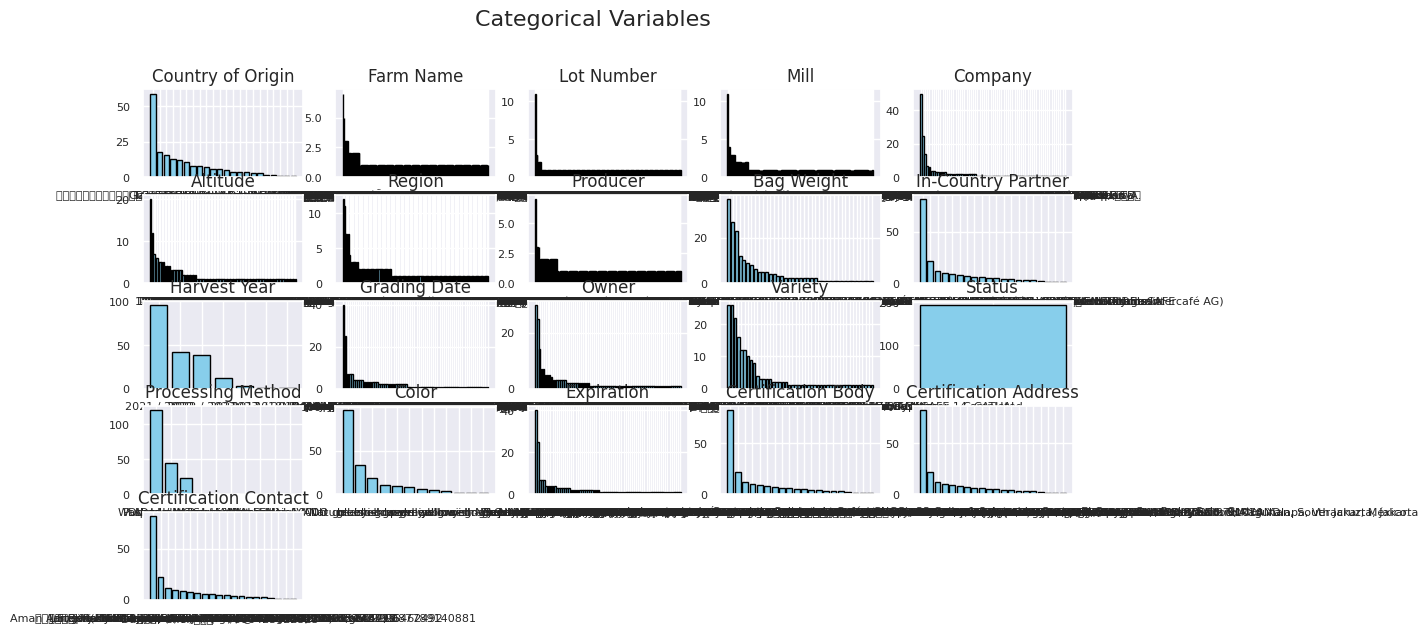

In [ ]:

df_categorical = df[categorical_columns]

fig, ax = plt.subplots(6,5,figsize=(12,8))
fig.suptitle("Categorical Variables", fontsize=16)
ax = ax.flatten()

# Plot a histogram for each column
for i, col in enumerate(df_categorical.columns):
    counts = df_categorical[col].value_counts()
    ax[i].bar(counts.index, counts.values, color='skyblue', edgecolor='black')
    ax[i].set_title(col)

# Hide any remaining empty subplots
for j in range(len(df_categorical.columns), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title
plt.show()

La mayor parte de los gráficos presentan distribuciones similares. Las variables categóricas tienen unos pocos valores muy comunes y una larga cola de valores distintos. Esto excepto Certification Adress, que termina teniendo un solo valor, y por ende se puede omitir del análisis.

In [87]:
df = df.drop(["Certification Address"],axis=1)

Vemos ahora correlación entre las variables numéricas


Correlations between the Variables



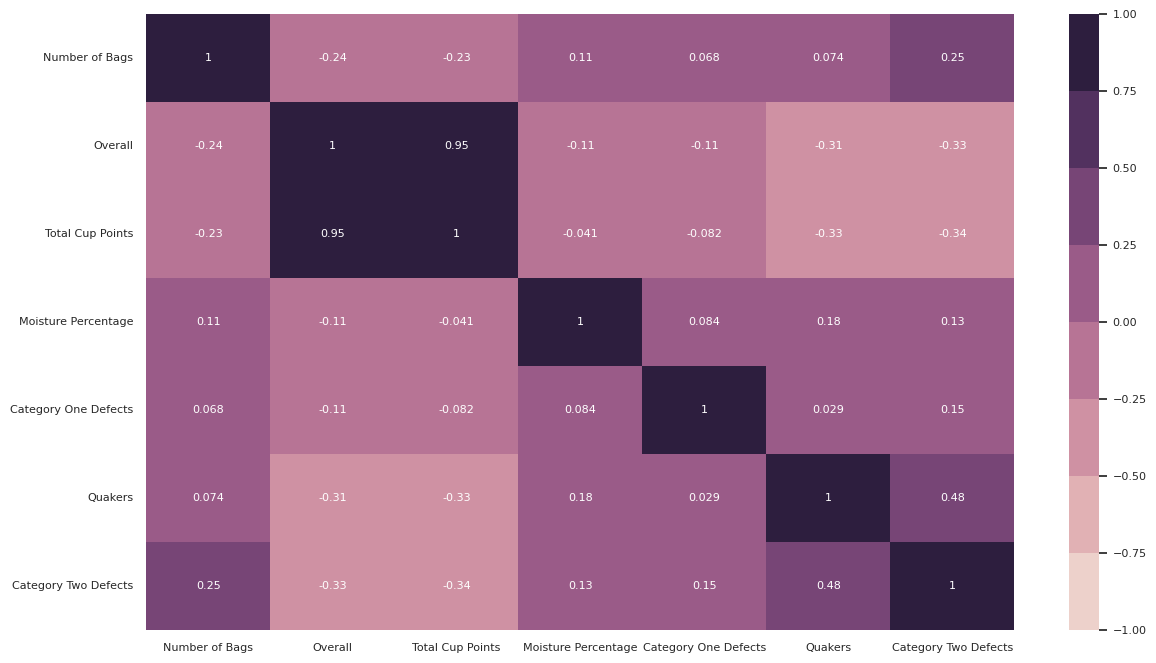

In [92]:
df_numerical = df[df.select_dtypes(include='number').columns]

plt.figure(figsize=(14, 8))
print('\nCorrelations between the Variables\n')
correlation = df_numerical.corr()
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap=sns.cubehelix_palette(8))
plt.show()

## Falta distribucion de cafes por cada nivel de calidad

### Data Preparation (Leandro)


#### Defining Two Classes (Nosotros empezamos con multiples clases, omitir esta)

RANDOM STATE 22078
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1071.000000       1071.000000  1071.000000     1071.000000   
mean        8.287582          0.529902     0.270644        2.562979   
std         1.717998          0.176416     0.194137        1.447427   
min         4.700000          0.120000     0.000000        0.900000   
25%         7.100000          0.400000     0.100000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.600000          1.580000     0.790000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1071.000000          1071.000000           1071.000000  1071.000000   
mean      0.087419            15.713352             46.171802     0.996765   
std       0.046120            10.261306             32.896920     0.001904   
min       0.012000           

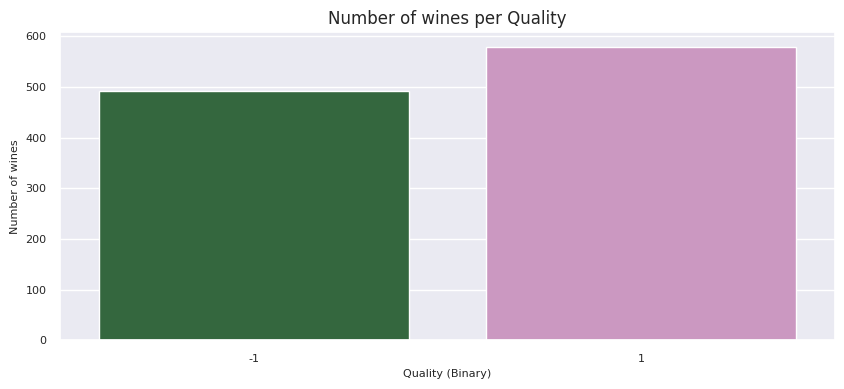

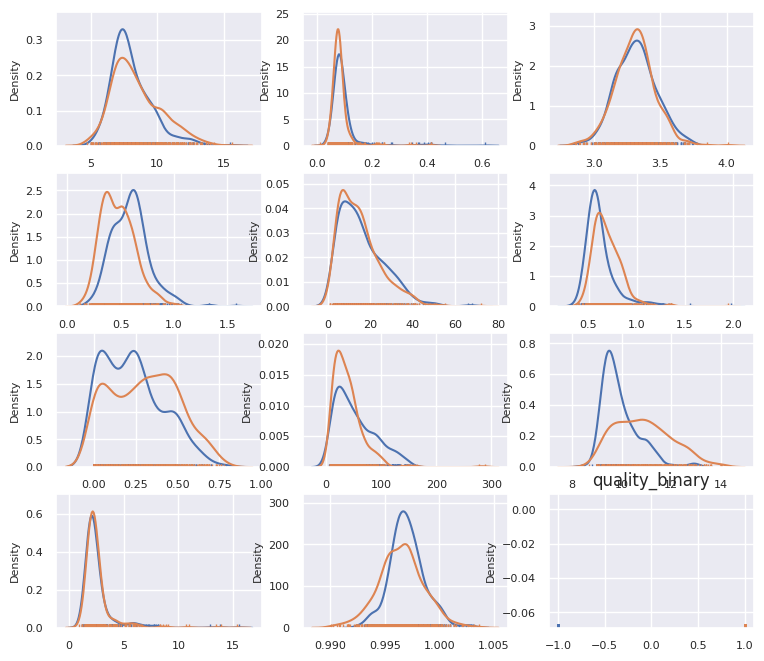

In [ ]:
wine_df_binary = wine_df.copy(deep=True)
wine_df_binary['quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] < 5.5, 'quality_binary'] = -1
wine_df_binary.loc[wine_df['quality'] >= 5.5, 'quality_binary'] = +1

X = wine_df_binary.drop(['quality','quality_binary'], axis=1).values
y = wine_df_binary['quality_binary'].values

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

wine_df_train = pd.DataFrame(X_train,columns=wine_df.columns[:-1])
wine_df_train['quality_binary'] = y_train
print(wine_df_train.describe()) #stats of each variable

fig, ax = plt.subplots(figsize=(10,4))
class_counts = wine_df_train['quality_binary'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts, palette="cubehelix")
ax.set_title('Number of wines per Quality') # Title
ax.set_ylabel('Number of wines') # Y label
ax.set_xlabel('Quality (Binary)') # X label
plt.show()

bad = wine_df_train.loc[wine_df_train['quality_binary'] == -1]
good = wine_df_train.loc[wine_df_train['quality_binary'] == 1]

fig, ax = plt.subplots(figsize=(9,8), nrows=4, ncols=3)
counter = 0
for var_name in wine_df_train.columns:
  j = counter//4; i = counter%4;
  sns.distplot(bad[var_name].values, hist=False, rug=True, ax=ax[i,j])
  sns.distplot(good[var_name].values, hist=False, rug=True, ax=ax[i,j])
  counter +=1

plt.title(var_name)
plt.show()

#### Scaling

RANDOM STATE 22078
       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.071000e+03      1.071000e+03  1.071000e+03    1.071000e+03   
mean    4.735293e-15      3.755062e-15 -1.572349e-15   -2.939033e-15   
std     1.000467e+00      1.000467e+00  1.000467e+00    1.000467e+00   
min    -2.089209e+00     -2.324586e+00 -1.394743e+00   -1.149457e+00   
25%    -6.915818e-01     -7.366842e-01 -8.794013e-01   -4.582532e-01   
50%    -2.257061e-01     -5.615480e-02 -5.485431e-02   -2.508921e-01   
75%     5.313419e-01      6.243746e-01  7.696926e-01    2.558938e-02   
max     4.258348e+00      5.955189e+00  2.676457e+00    8.942117e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.071000e+03         1.071000e+03          1.071000e+03  1.071000e+03   
mean   4.501431e-15         8.458842e-17          1.907386e-17 -2.330245e-13   
std    1.000467e+00         1.000467e+00          1.000467e+00  1.000467e+00   
min   -1.636

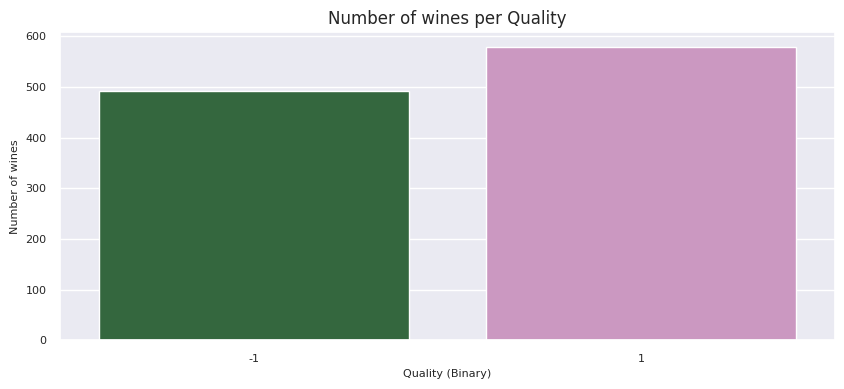

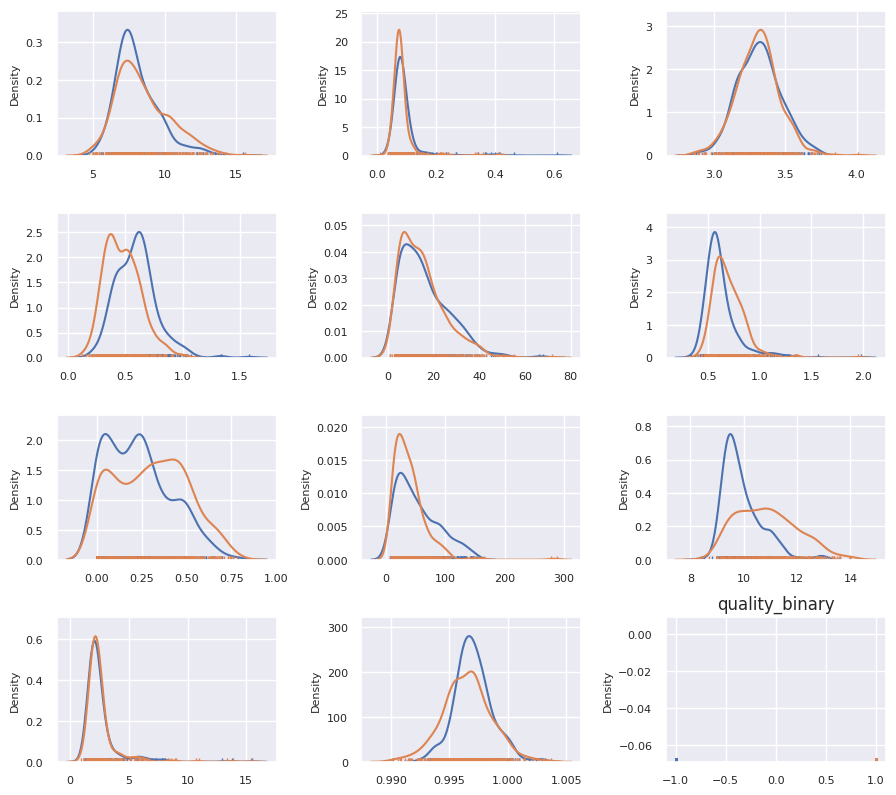

In [ ]:
wine_df_binary = wine_df.copy(deep=True)
wine_df_binary['quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] < 5.5, 'quality_binary'] = -1
wine_df_binary.loc[wine_df['quality'] >= 5.5, 'quality_binary'] = +1

X = wine_df_binary.drop(['quality','quality_binary'], axis=1).values
y = wine_df_binary['quality_binary'].values

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

wine_df_train = pd.DataFrame(X_train_scaled,columns=wine_df.columns[:-1])
wine_df_train['quality_binary'] = y_train
print(wine_df_train.describe()) #stats of each variable

fig, ax = plt.subplots(figsize=(10,4))
class_counts = wine_df_train['quality_binary'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts, palette="cubehelix")
ax.set_title('Number of wines per Quality') # Title
ax.set_ylabel('Number of wines') # Y label
ax.set_xlabel('Quality (Binary)') # X label
plt.show()

fig, ax = plt.subplots(figsize=(9,8), nrows=4, ncols=3)
counter = 0
for var_name in wine_df_train.columns:
  j = counter//4; i = counter%4;
  sns.distplot(bad[var_name].values, hist=False, rug=True, ax=ax[i,j])
  sns.distplot(good[var_name].values, hist=False, rug=True, ax=ax[i,j])
  counter +=1
  plt.title(var_name)

plt.tight_layout()
plt.show()

#### Outlier Removal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1071 non-null   float64
 1   volatile acidity      1071 non-null   float64
 2   citric acid           1071 non-null   float64
 3   residual sugar        1071 non-null   float64
 4   chlorides             1071 non-null   float64
 5   free sulfur dioxide   1071 non-null   float64
 6   total sulfur dioxide  1071 non-null   float64
 7   density               1071 non-null   float64
 8   pH                    1071 non-null   float64
 9   sulphates             1071 non-null   float64
 10  alcohol               1071 non-null   float64
 11  quality_binary        1071 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 100.5 KB
None
       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.071000e+03      1.071000e+03  1.071000e

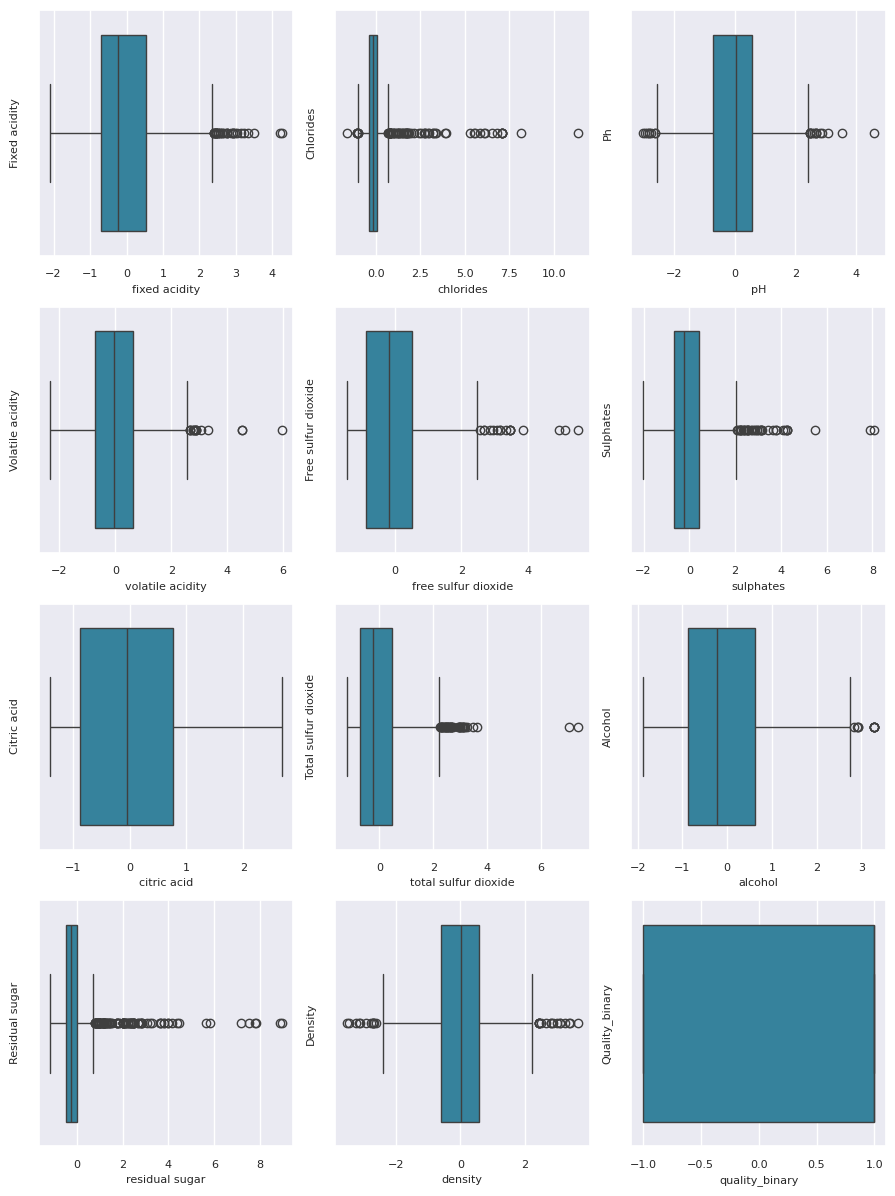

<class 'pandas.core.frame.DataFrame'>
Index: 991 entries, 0 to 1070
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         991 non-null    float64
 1   volatile acidity      991 non-null    float64
 2   citric acid           991 non-null    float64
 3   residual sugar        991 non-null    float64
 4   chlorides             991 non-null    float64
 5   free sulfur dioxide   991 non-null    float64
 6   total sulfur dioxide  991 non-null    float64
 7   density               991 non-null    float64
 8   pH                    991 non-null    float64
 9   sulphates             991 non-null    float64
 10  alcohol               991 non-null    float64
 11  quality_binary        991 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 100.6 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count     991.000000        991.000000   991.000000     

In [ ]:
print(wine_df_train.info())#basic info of each variable
print(wine_df_train.describe()) #stats of each variable

fig, ax = plt.subplots(figsize=(9,12), nrows=4, ncols=3)
counter = 0
for column in wine_df_train.columns:
  j = counter//4; i = counter%4;
  sns.boxplot(x = column, data = wine_df_train,ax=ax[i,j],palette="PuBuGn_d")
  ax[i,j].set_ylabel(column.capitalize()) # Y label
  counter +=1
plt.tight_layout()
plt.show()

col = 'chlorides'

Q1 = wine_df_train[col].quantile(0.25)
Q3  = wine_df_train[col].quantile(0.75)


IQR = Q3-Q1
wine_train_filtered_df = wine_df_train[wine_df_train[col] < Q3 + 1.5*IQR]
wine_train_filtered_df = wine_train_filtered_df[wine_df_train[col] > Q1 - 1.5*IQR]

print(wine_train_filtered_df .info())#basic info of each variable
print(wine_train_filtered_df .describe()) #stats of each variable


### Linear SVM Definition and Training (Ivan)

#### Default Parameters

In [ ]:
from sklearn.svm import SVC
class_weights = dict()

class_weights[0] = 10
class_weights[1] = 0.1

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='linear',C=10)

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))

GLOBAL ACCURACY TRAIN SET (LIB) 0.734827264239029
GLOBAL ACCURACY TEST SET (LIB) 0.7689393939393939

DETAILED REPORT TEST SET:

              precision    recall  f1-score   support

         bad       0.76      0.75      0.76       252
        good       0.78      0.78      0.78       276

    accuracy                           0.77       528
   macro avg       0.77      0.77      0.77       528
weighted avg       0.77      0.77      0.77       528



#### Effect of Regularization Parameter (C)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


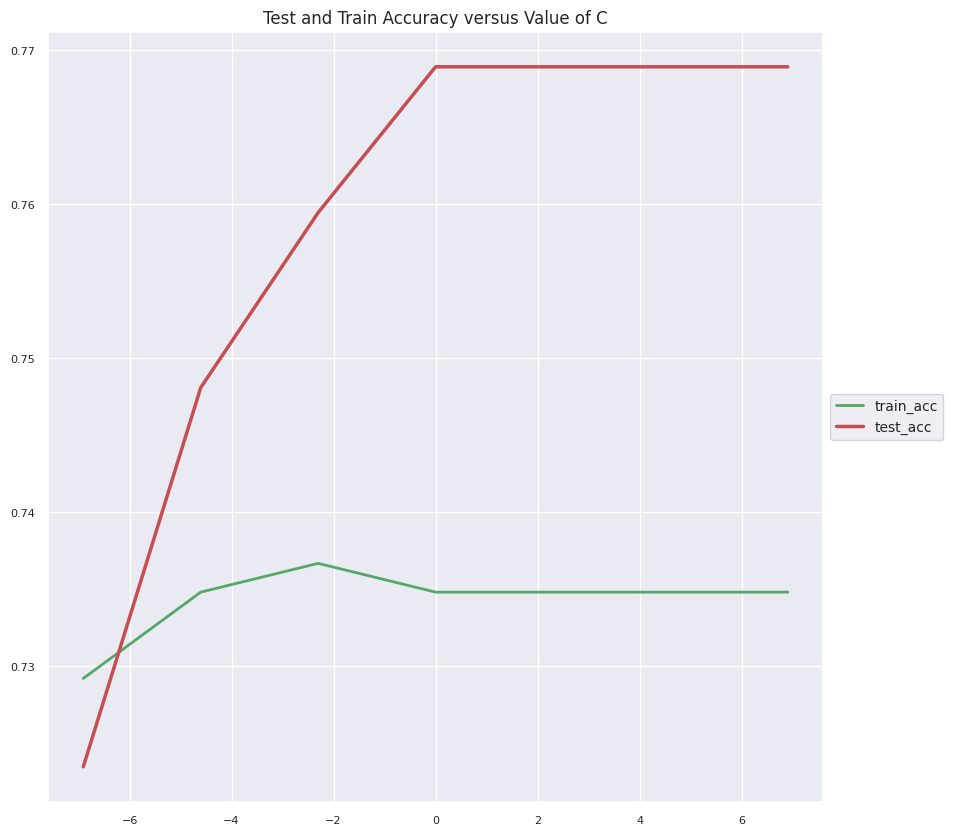

In [ ]:
from sklearn.svm import SVC

C_values = np.logspace(-3, 3, num=7, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='linear', C=C_val)
  svm.fit(X_train_scaled,y_train)
  train_accuracy.append(svm.score(X_train_scaled,y_train))
  test_accuracy.append(svm.score(X_test_scaled,y_test))


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
plt.title("Test and Train Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Model Selection (USING A VALIDATION SET)

6254
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


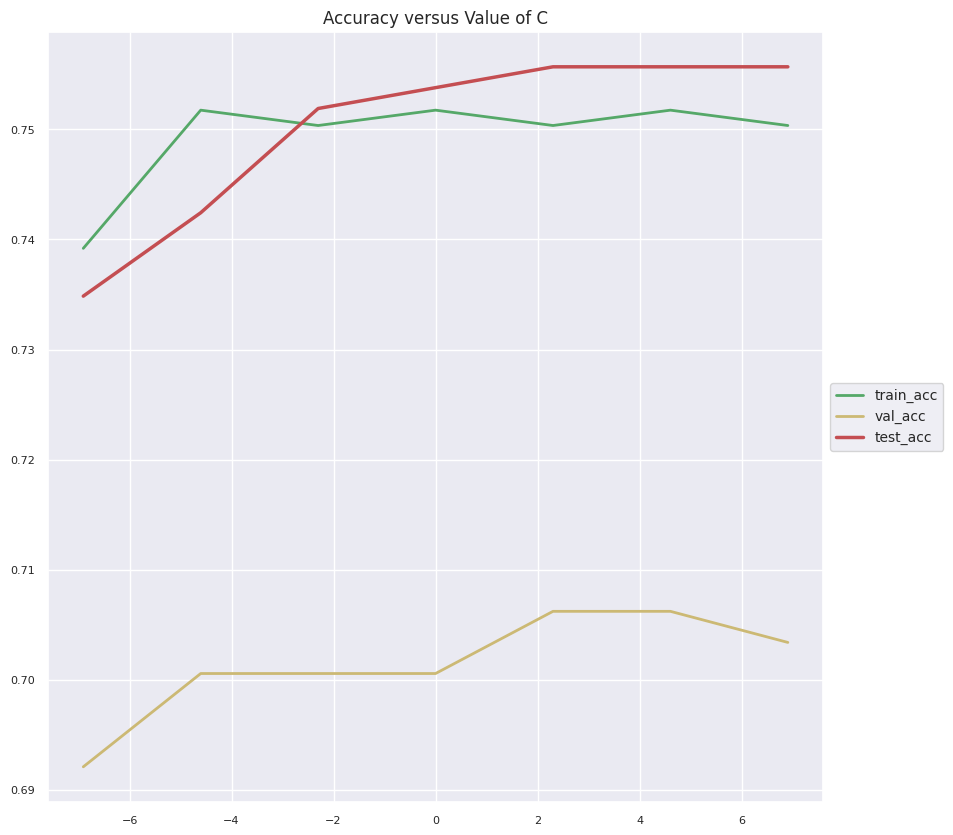

In [ ]:
from sklearn.model_selection import train_test_split
import random, sys

rn = random.randint(0, 100000)
print(rn)#1158
rn = 1158

X_train_sel, X_val, y_train_sel, y_val = train_test_split(X_train_scaled, y_train, test_size=0.33, random_state=rn)

C_values = np.logspace(-3, 3, num=7, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
val_accuracy = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='linear', C=C_val)
  svm.fit(X_train_sel,y_train_sel)
  train_accuracy.append(svm.score(X_train_sel,y_train_sel))
  val_accuracy.append(svm.score(X_val,y_val))
  test_accuracy.append(svm.score(X_test_scaled,y_test))


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),val_accuracy,color='y',lw=2.,label='val_acc')
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy versus Value of C")
plt.show()

#### Model Selection (USING CROSS-VALIDATION)

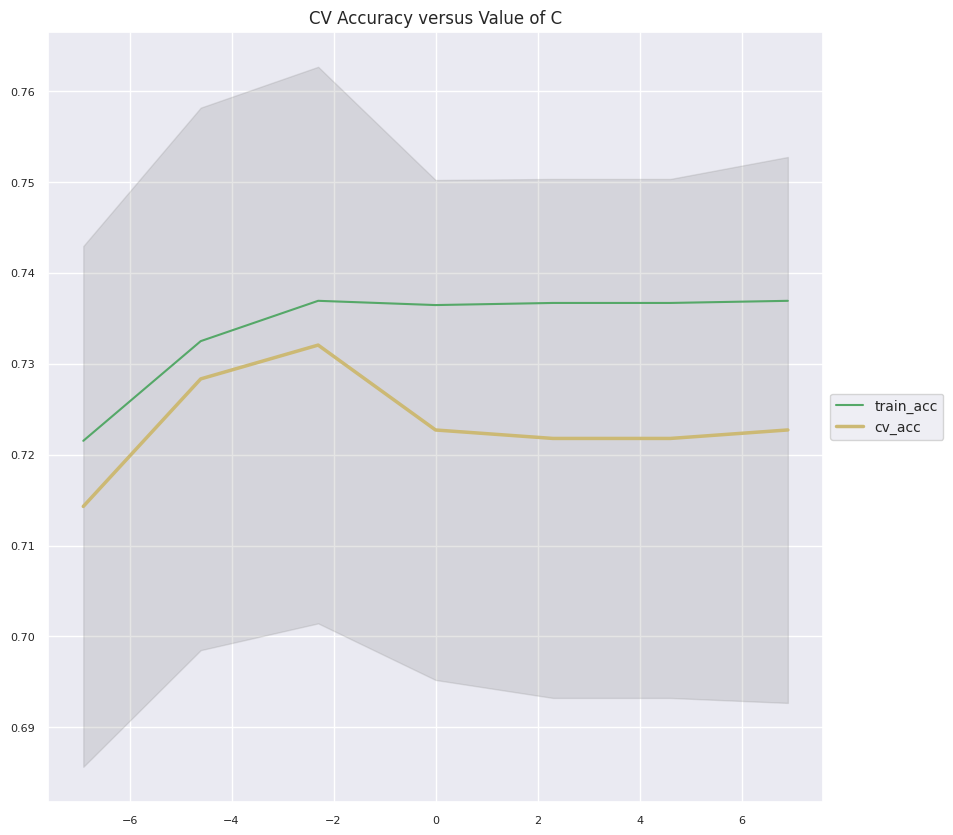

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['linear'], 'C': np.logspace(-3, 3, num=7, endpoint=True, base=10.0)}
svm = SVC()
gs = GridSearchCV(svm, parameters,return_train_score=True)
gs.fit(X_train_scaled,y_train)


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),gs.cv_results_['mean_train_score'],color='g',lw=1.5,label='train_acc')
ax.plot(np.log(C_values),gs.cv_results_['mean_test_score'],color='y',lw=2.5,label='cv_acc')
plt.fill_between(np.log(C_values), gs.cv_results_['mean_test_score']-gs.cv_results_['std_test_score'], gs.cv_results_['mean_test_score']+gs.cv_results_['std_test_score'],color='gray', alpha=0.2)
plt.title("CV Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Non-linear SVM Definition and Training (Ivan)

#### Default Parameters


In [ ]:
from sklearn.svm import SVC
class_weights = dict()

class_weights[0] = 10
class_weights[1] = 0.1

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='rbf')

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))

GLOBAL ACCURACY TRAIN SET (LIB) 0.7955182072829131
GLOBAL ACCURACY TEST SET (LIB) 0.7803030303030303

DETAILED REPORT TEST SET:

              precision    recall  f1-score   support

         bad       0.78      0.76      0.77       252
        good       0.78      0.80      0.79       276

    accuracy                           0.78       528
   macro avg       0.78      0.78      0.78       528
weighted avg       0.78      0.78      0.78       528



#### Effect of Regularization Parameter

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]


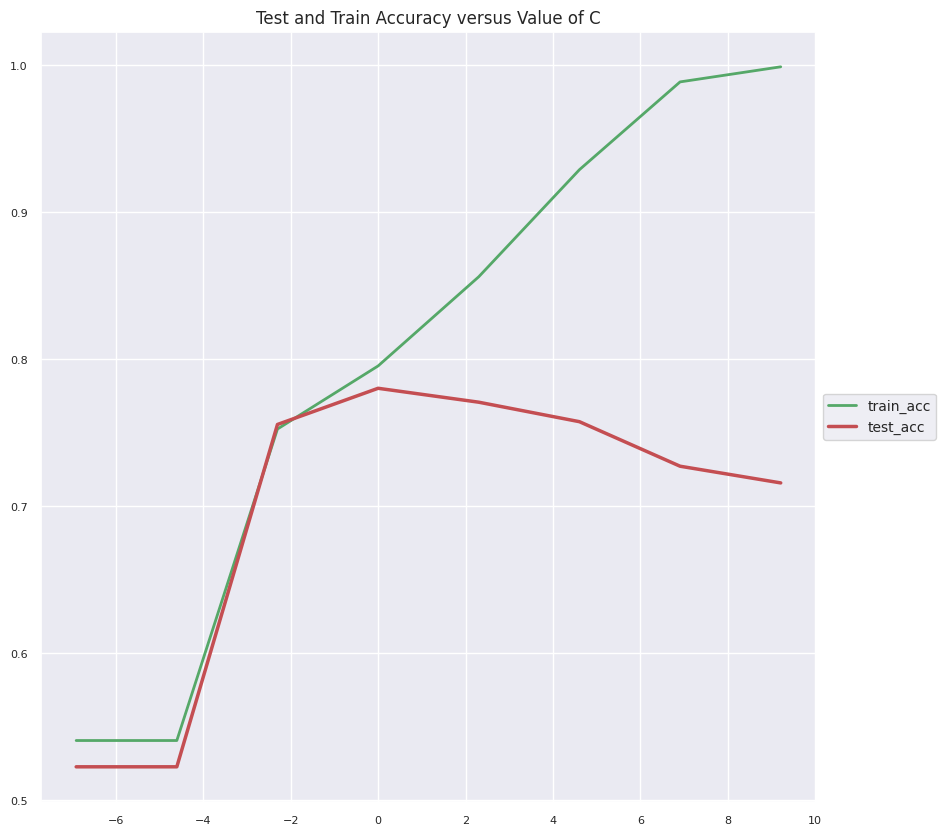

In [ ]:
from sklearn.svm import SVC

C_values = np.logspace(-3, 4, num=8, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='rbf', C=C_val)
  svm.fit(X_train_scaled,y_train)
  train_accuracy.append(svm.score(X_train_scaled,y_train))
  test_accuracy.append(svm.score(X_test_scaled,y_test))


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
plt.title("Test and Train Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Model Selection - I

23644
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]


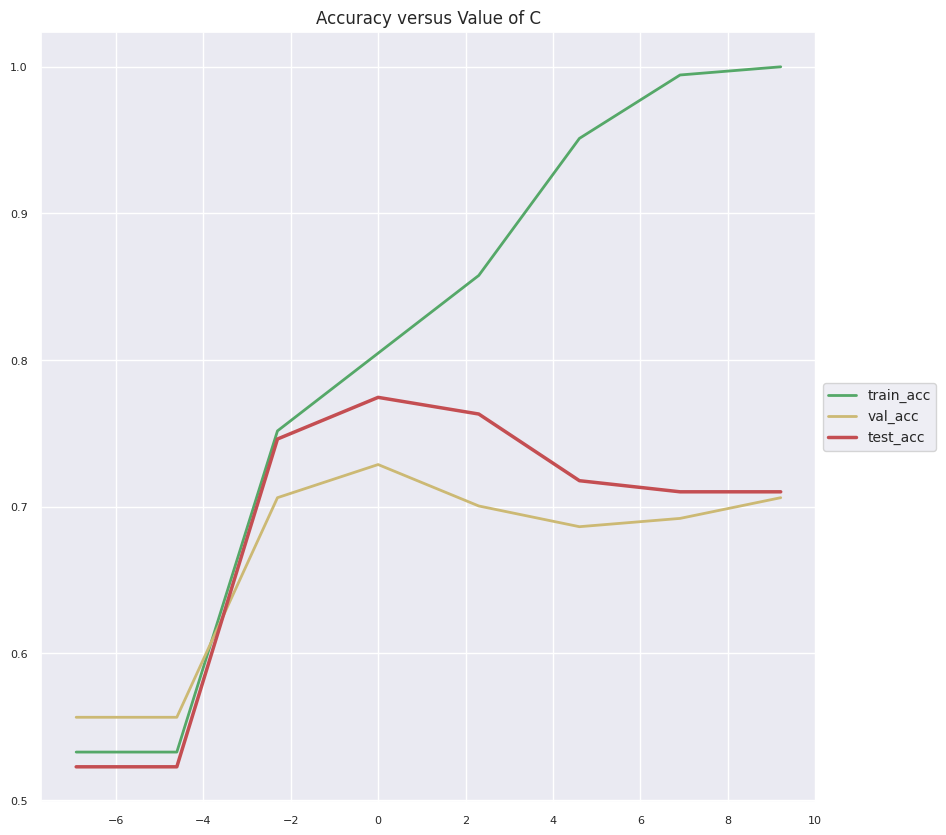

In [ ]:
from sklearn.model_selection import train_test_split
import random, sys

rn = random.randint(0, 100000)
print(rn)#1158
rn = 1158

X_train_sel, X_val, y_train_sel, y_val = train_test_split(X_train_scaled, y_train, test_size=0.33, random_state=rn)

C_values = np.logspace(-3, 4, num=8, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
val_accuracy = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='rbf', C=C_val)
  svm.fit(X_train_sel,y_train_sel)
  train_accuracy.append(svm.score(X_train_sel,y_train_sel))
  val_accuracy.append(svm.score(X_val,y_val))
  test_accuracy.append(svm.score(X_test_scaled,y_test))


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),val_accuracy,color='y',lw=2.,label='val_acc')
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy versus Value of C")
plt.show()

#### Model Selection II

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]


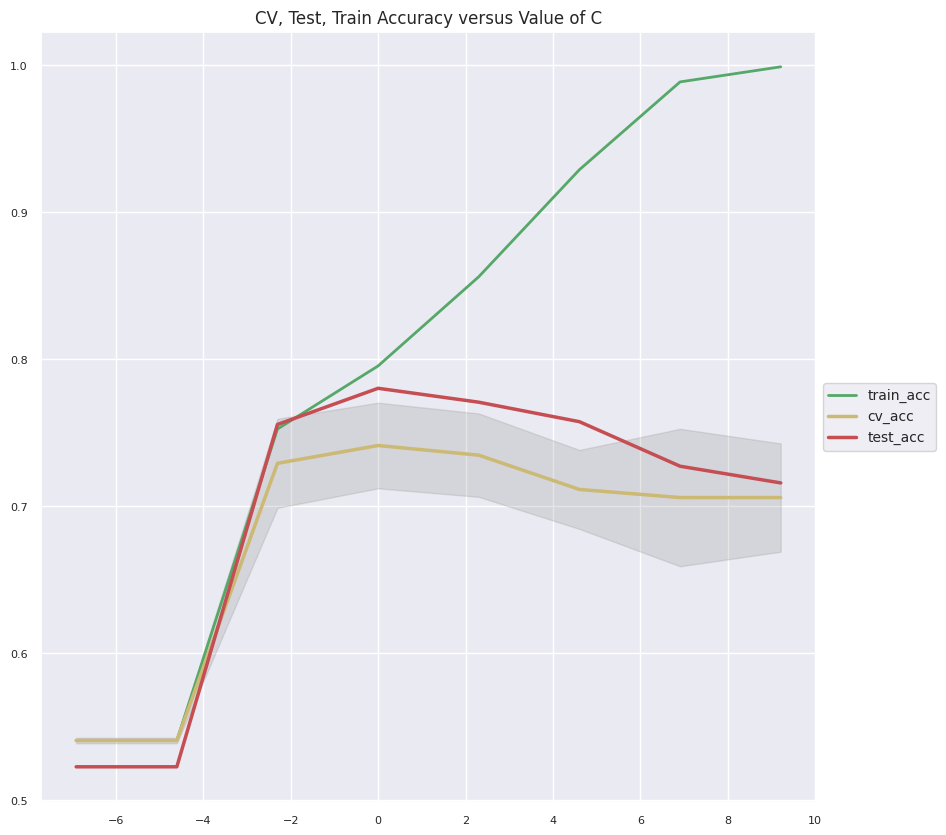

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

C_values = np.logspace(-3, 4, num=8, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
cross_val_accuracy = []
cross_val_std = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='rbf', C=C_val)
  cv_output = cross_val_score(svm, X_train_scaled, y_train, cv=5)
  cross_val_accuracy.append(cv_output.mean())
  cross_val_std.append(cv_output.std())
  svm = SVC(kernel='rbf', C=C_val)
  svm.fit(X_train_scaled,y_train)
  train_accuracy.append(svm.score(X_train_scaled,y_train))
  test_accuracy.append(svm.score(X_test_scaled,y_test))

cross_val_accuracy = np.array(cross_val_accuracy)
cross_val_std = np.array(cross_val_std)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),cross_val_accuracy,color='y',lw=2.5,label='cv_acc')
plt.fill_between(np.log(C_values), cross_val_accuracy-cross_val_std, cross_val_accuracy+cross_val_std,color='gray', alpha=0.2)
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
plt.title("CV, Test, Train Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Model Selection III

In [ ]:
#### TUNE THE KERNELIZED MACHINE
print("\nTUNNING TWO PARAMETERS OF A NON-LINEAR SVM ...\n")
parameters_rbf = {'C': np.logspace(-3, 4, num=8, endpoint=True, base=10.0), 'gamma': [0.01, 0.1], 'kernel': ['rbf']}

svm = SVC()
grid_result_rbf = GridSearchCV(svm, parameters_rbf,return_train_score=True)
grid_result_rbf.fit(X_train_scaled,y_train)

means = grid_result_rbf.cv_results_['mean_test_score']
stds = grid_result_rbf.cv_results_['std_test_score']
params = grid_result_rbf.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))#param is a dict with the fields you created
    #print(param['kernel'],param['C'])#you can access the fields to see the param values

print("\nBEST RESULTS FOR NON-LINEAR SVM ...\n")
print("PARAMS: ",grid_result_rbf.best_params_)
print("SCORE: ",grid_result_rbf.best_score_)

#### TUNE THE LINEAR MACHINE AND NON-LINEAR AT THE SAME TIME
print("\nTUNNING THE SVM INCLUDING DIFFERENT KERNELS ...\n")
parameters = [
  {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'kernel': ['linear']},
  {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'gamma': [0.01, 0.02, 0.1, 0.2], 'kernel': ['rbf']},
 ]

svm = SVC()
grid_result = GridSearchCV(svm, parameters,return_train_score=True)
grid_result.fit(X_train_scaled,y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))#param is a dict with the fields you created
    #print(param['kernel'],param['C'])#you can access the fields to see the param values

print("\nBEST RESULTS ...\n")
print("PARAMS: ",grid_result.best_params_)
print("SCORE: ",grid_result.best_score_)



TUNNING THE NON-LINEAR SVM IN TWO PARAMETERS ...

0.540617 (0.001889) with: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.540617 (0.001889) with: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.540617 (0.001889) with: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.540617 (0.001889) with: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.715240 (0.037442) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.727381 (0.027561) with: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.725525 (0.026249) with: {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.742300 (0.026798) with: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.740452 (0.023846) with: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.734792 (0.022546) with: {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.732028 (0.022598) with: {'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.704003 (0.033347) with: {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.732954 (0.008222) with: {'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.710611 (0.043646) with: {'C': 1000.0, 'ga

### Examining the Linear Model (Benja)


VALUE OF INTERCEPT 0.1610456448034283
PERC. POSITIVE CLASS: 0.5406162464985994
PERC. NEGATIVE CLASS: 0.0


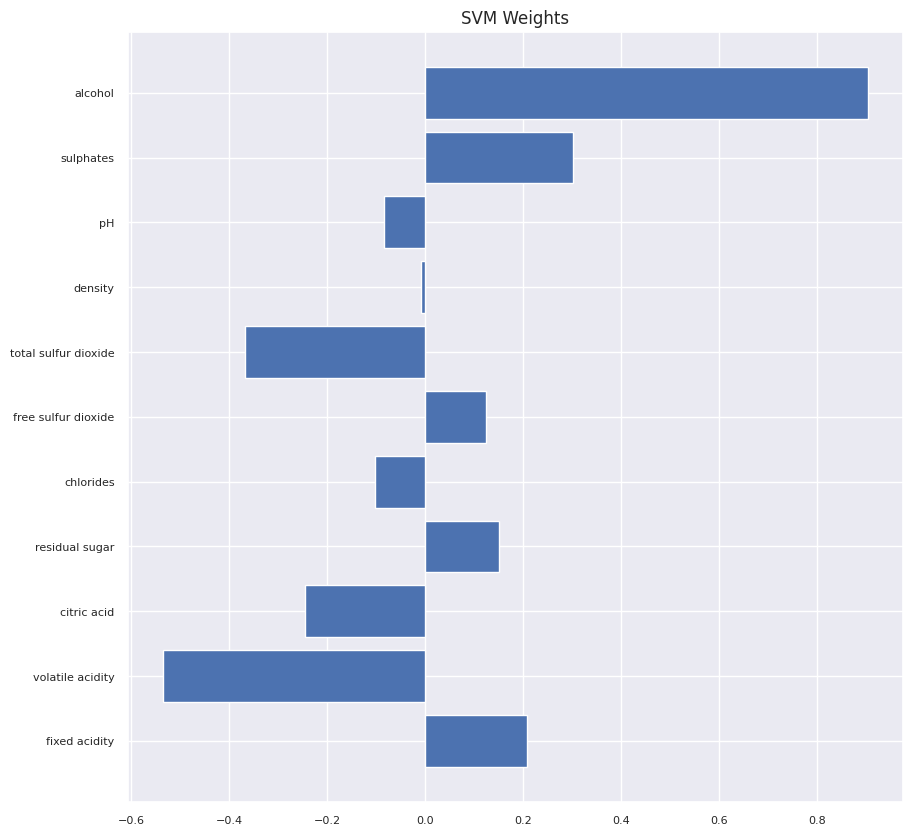

In [ ]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_scaled,y_train)

w = svm.coef_[0]
b = svm.intercept_[0]

#print(w.shape)
print("VALUE OF INTERCEPT", b)
print("PERC. POSITIVE CLASS:", np.sum(y_train==1)/len(y_train))
print("PERC. NEGATIVE CLASS:", np.sum(y_train==0)/len(y_train))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
var_idx = range(0,len(w))
ax.barh(var_idx, w, align='center')
ax.set_yticks(var_idx)
ax.set_yticklabels(wine_df_train.columns[:-1])
plt.title("SVM Weights")
plt.show()



### Support Vectors in the Linear and Non-linear Model (Benja)

# COSAS UTILES

NUMBER OF SUPPORT VECTORS %d [324 322]


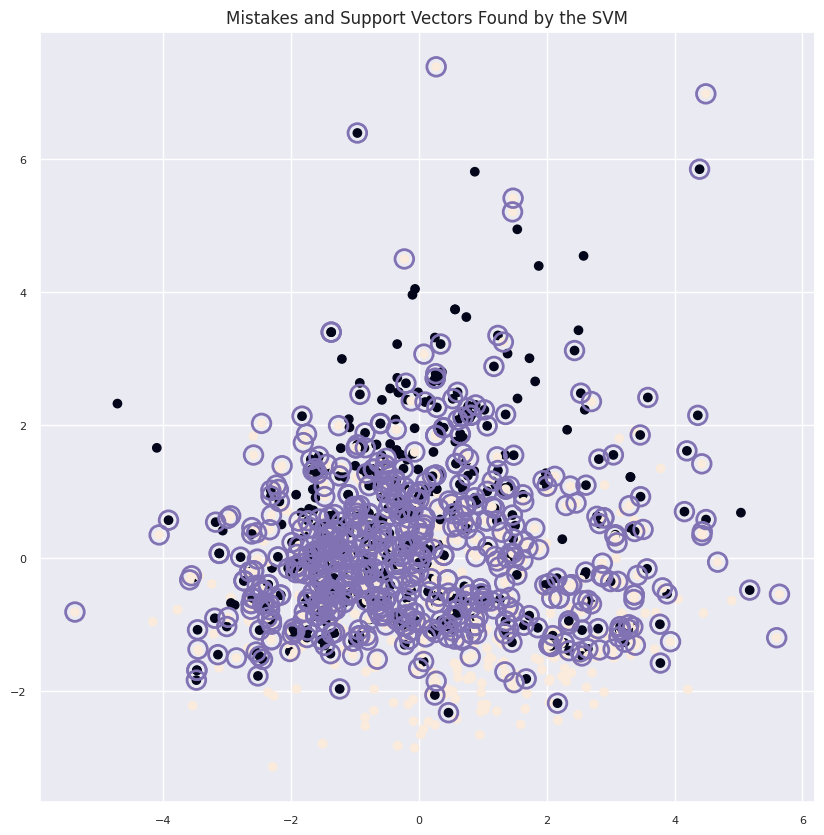

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_proyected = pca.transform(X_train_scaled)
y_pred_train = svm.predict(X_train_scaled)
decision_train = svm.decision_function(X_train_scaled)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_proyected[:,0],X_train_proyected[:,1],c=y_train)

X_mistakes = X_train_scaled[y_train != y_pred_train]
X_mistakes_proyected = pca.transform(X_mistakes)
#ax.scatter(X_mistakes_proyected[:,0],X_mistakes_proyected[:,1], s=280, facecolors='none',edgecolors='r',linewidth=3.5)

sv = svm.support_vectors_ #support vectors
nsv = svm.n_support_ #number of support vectors
sv_idx = svm.support_ #indices of support vectors
sv_proyected = pca.transform(sv)

print("NUMBER OF SUPPORT VECTORS %d", nsv)

ax.scatter(sv_proyected[:,0],sv_proyected[:,1], s=180, facecolors='none',edgecolors='m',linewidth=2)

plt.title("Mistakes and Support Vectors Found by the SVM")
plt.show()



### Training for Multiple Classes

#### Preparing the Data

[0 1 2]
RANDOM STATE 22078
       fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.071000e+03      1.071000e+03  1.071000e+03    1.071000e+03   
mean    4.735293e-15      3.755062e-15 -1.572349e-15   -2.939033e-15   
std     1.000467e+00      1.000467e+00  1.000467e+00    1.000467e+00   
min    -2.089209e+00     -2.324586e+00 -1.394743e+00   -1.149457e+00   
25%    -6.915818e-01     -7.366842e-01 -8.794013e-01   -4.582532e-01   
50%    -2.257061e-01     -5.615480e-02 -5.485431e-02   -2.508921e-01   
75%     5.313419e-01      6.243746e-01  7.696926e-01    2.558938e-02   
max     4.258348e+00      5.955189e+00  2.676457e+00    8.942117e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.071000e+03         1.071000e+03          1.071000e+03  1.071000e+03   
mean   4.501431e-15         8.458842e-17          1.907386e-17 -2.330245e-13   
std    1.000467e+00         1.000467e+00          1.000467e+00  1.000467e+00   
min 

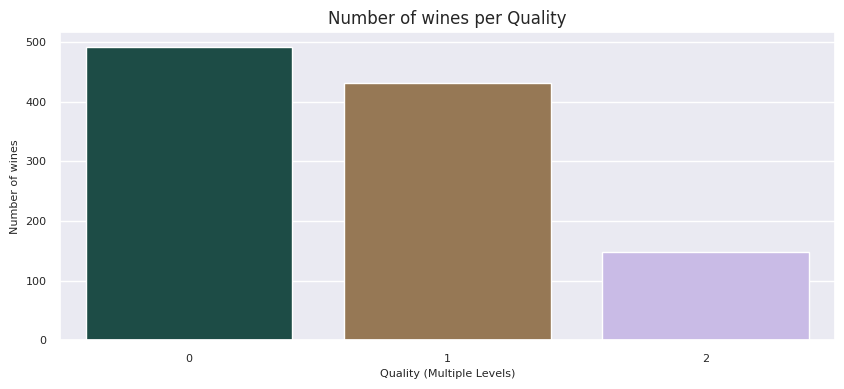

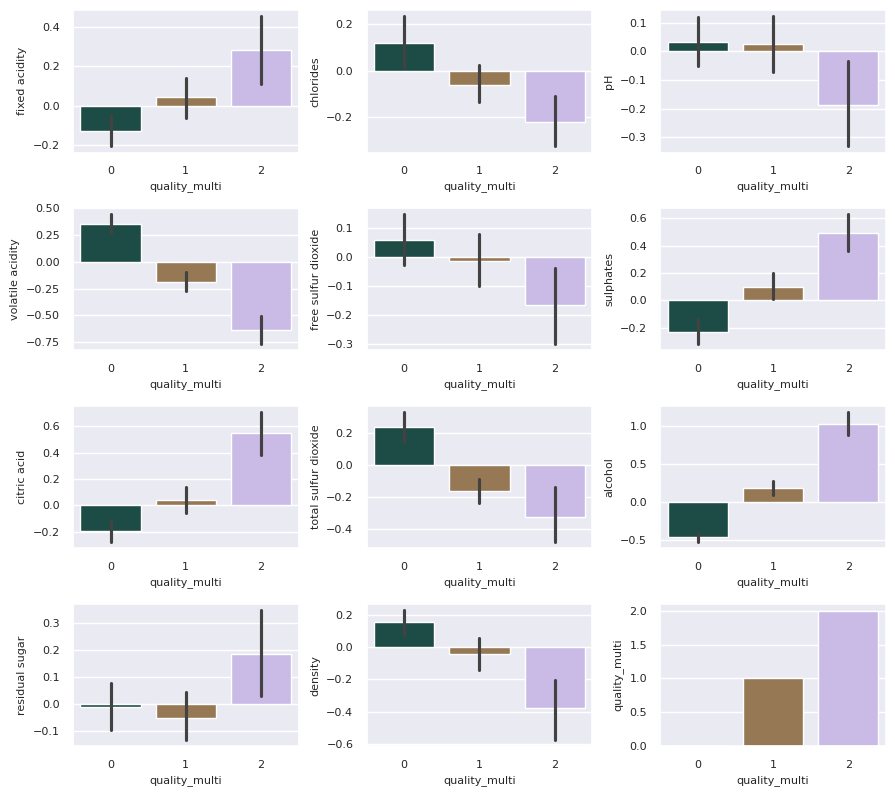

In [ ]:
wine_df_multi = wine_df.copy(deep=True)
wine_df_multi['quality_multi'] = 0
wine_df_multi.loc[wine_df['quality'] <= 5, 'quality_multi'] = 0
wine_df_multi.loc[(wine_df['quality'] > 5) & (wine_df['quality'] <= 6), 'quality_multi'] = 1
wine_df_multi.loc[wine_df['quality'] >= 7, 'quality_multi'] = 2

X = wine_df_multi.drop(['quality','quality_multi'], axis=1).values
y = wine_df_multi['quality_multi'].values

print(np.unique(y))

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

wine_df_train = pd.DataFrame(X_train_scaled,columns=wine_df.columns[:-1])
wine_df_train['quality_multi'] = y_train
print(wine_df_train.describe()) #stats of each variable

fig, ax = plt.subplots(figsize=(10,4))
class_counts = wine_df_train['quality_multi'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts, palette="cubehelix")
ax.set_title('Number of wines per Quality') # Title
ax.set_ylabel('Number of wines') # Y label
ax.set_xlabel('Quality (Multiple Levels)') # X label
plt.show()

fig, ax = plt.subplots(figsize=(9,8), nrows=4, ncols=3)
counter = 0
for column in wine_df_train.columns:
  if column != 'quality': #we skip the variable original quality -> 0-10
    j = counter//4; i = counter%4;
    sns.barplot(x = 'quality_multi', y = column, data = wine_df_train,ax=ax[i,j],palette="cubehelix")
    #ax[i,j].set_title('%s versus quality'%column.capitalize())
    ax[i,j].set_ylabel(column) # Y label
    #ax[i,j].set_xlabel('Quality (Binary)') # X label
    counter +=1
plt.tight_layout()
plt.show()




#### Model Training and Evaluation


In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsRestClassifier

svm = OneVsRestClassifier(SVC(kernel='rbf',C=1))
svm.fit(X_train_scaled,y_train)

print("OVR ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("OVR ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

#print("\nOVR DETAILED REPORT TEST SET:\n")
#print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))


svm = OneVsOneClassifier(SVC(kernel='rbf',C=1))
svm.fit(X_train_scaled,y_train)

print("OVO ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("OVO ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

#print("\nOVO DETAILED REPORT TEST SET:\n")
#print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))


svm = OutputCodeClassifier(SVC(kernel='rbf',C=1),code_size=10)
svm.fit(X_train_scaled,y_train)

print("ECOC ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("ECOC ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

#print("\nECOC DETAILED REPORT TEST SET:\n")
#print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))




OVR ACCURACY TRAIN SET (LIB) 0.707749766573296
OVR ACCURACY TEST SET (LIB) 0.6799242424242424
OVO ACCURACY TRAIN SET (LIB) 0.704014939309057
OVO ACCURACY TEST SET (LIB) 0.6742424242424242
ECOC ACCURACY TRAIN SET (LIB) 0.7096171802054155
ECOC ACCURACY TEST SET (LIB) 0.6837121212121212


### Evaluating the Models beyond Accuracy

In [ ]:
from sklearn.svm import SVC
class_weights = dict()

class_weights[0] = 10
class_weights[1] = 0.1

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='rbf')

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
#print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))

GLOBAL ACCURACY TRAIN SET (LIB) 0.7012138188608776
GLOBAL ACCURACY TEST SET (LIB) 0.6723484848484849

DETAILED REPORT TEST SET:

              precision    recall  f1-score   support

         bad       0.74      0.79      0.76       252
     average       0.59      0.65      0.62       207
        good       0.65      0.32      0.43        69

    accuracy                           0.67       528
   macro avg       0.66      0.59      0.60       528
weighted avg       0.67      0.67      0.66       528



### Dealing with Unbalanced Data

RANDOM STATE 22078


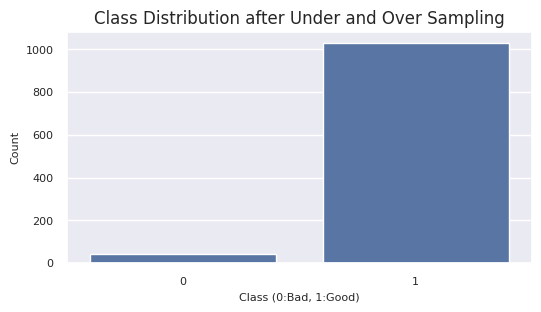

GLOBAL ACCURACY TRAIN SET (LIB) 0.9607843137254902
GLOBAL ACCURACY TEST SET (LIB) 0.9602272727272727

DETAILED REPORT TEST SET:

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00        21
        good       0.96      1.00      0.98       507

    accuracy                           0.96       528
   macro avg       0.48      0.50      0.49       528
weighted avg       0.92      0.96      0.94       528



In [ ]:
wine_df_binary = wine_df.copy(deep=True)
wine_df_binary['quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] < 4.5, 'quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] >= 4.5, 'quality_binary'] = 1

X = wine_df_binary.drop(['quality','quality_binary'], axis=1).values
y = wine_df_binary['quality_binary'].values

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_df = pd.DataFrame(X_train_scaled)
final_df["Class"] = y_train
class_counts = final_df["Class"].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts)
plt.title('Class Distribution after Under and Over Sampling')
plt.ylabel('Count')
plt.xlabel('Class (0:Bad, 1:Good)')
plt.show()

from sklearn.svm import SVC
class_weights = dict()

#class_weights[0] = 1
#class_weights[1] = 2

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='rbf')

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))


RANDOM STATE 22078


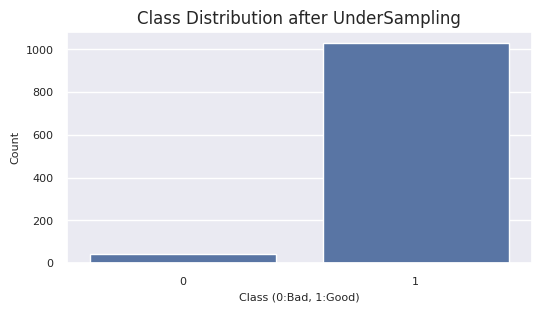

(1071, 11) (1071,)
42
1029
(126, 11) (126,)


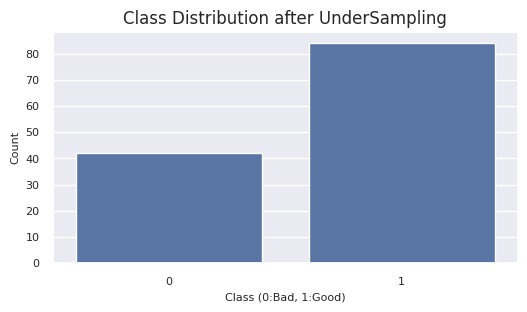

(168, 11) (168,)


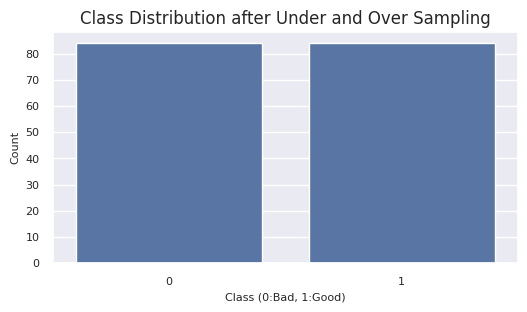

In [ ]:
wine_df_binary = wine_df.copy(deep=True)
wine_df_binary['quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] < 4.5, 'quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] >= 4.5, 'quality_binary'] = 1

X = wine_df_binary.drop(['quality','quality_binary'], axis=1).values
y = wine_df_binary['quality_binary'].values

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

final_df = pd.DataFrame(X_train)
final_df["Class"] = y_train
class_counts = final_df["Class"].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts)
plt.title('Class Distribution after UnderSampling')
plt.ylabel('Count')
plt.xlabel('Class (0:Bad, 1:Good)')
plt.show()

print(X_train.shape,y_train.shape)
print(np.sum(y_train==0))
print(np.sum(y_train==1))

under = RandomUnderSampler(sampling_strategy=0.5,random_state=rn)
X_train, y_train = under.fit_resample(X_train, y_train)
#X_test, y_test = under.fit_resample(X_test, y_test)

print(X_train.shape,y_train.shape)

final_df = pd.DataFrame(X_train)
final_df["Class"] = y_train
class_counts = final_df["Class"].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts)
plt.title('Class Distribution after UnderSampling')
plt.ylabel('Count')
plt.xlabel('Class (0:Bad, 1:Good)')
plt.show()

over = SMOTE(sampling_strategy=1,random_state=rn)
X_train, y_train = over.fit_resample(X_train, y_train)
#X_test, y_test = over.fit_resample(X_test, y_test)

print(X_train.shape,y_train.shape)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_df = pd.DataFrame(X_train_scaled)
final_df["Class"] = y_train
class_counts = final_df["Class"].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts)
plt.title('Class Distribution after Under and Over Sampling')
plt.ylabel('Count')
plt.xlabel('Class (0:Bad, 1:Good)')
plt.show()



In [ ]:
from sklearn.svm import SVC
class_weights = dict()

class_weights[0] = 1
class_weights[1] = 5

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='rbf',C=1,class_weight=class_weights)

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))

GLOBAL ACCURACY TRAIN SET (LIB) 0.7916666666666666
GLOBAL ACCURACY TEST SET (LIB) 0.9261363636363636

DETAILED REPORT TEST SET:

              precision    recall  f1-score   support

         bad       0.22      0.33      0.26        21
        good       0.97      0.95      0.96       507

    accuracy                           0.93       528
   macro avg       0.60      0.64      0.61       528
weighted avg       0.94      0.93      0.93       528



### Feature Engineering



Rug Plots and Approximate Distribution of Each Variable

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
quality
log-fixed acidity
0 0
log-volatile acidity
1 0
log-citric acid
2 0
log-residual sugar
3 0
log-chlorides
0 1
log-free sulfur dioxide
1 1
log-total sulfur dioxide
2 1
log-density
3 1
log-pH
0 2
log-sulphates
1 2
log-alcohol
2 2


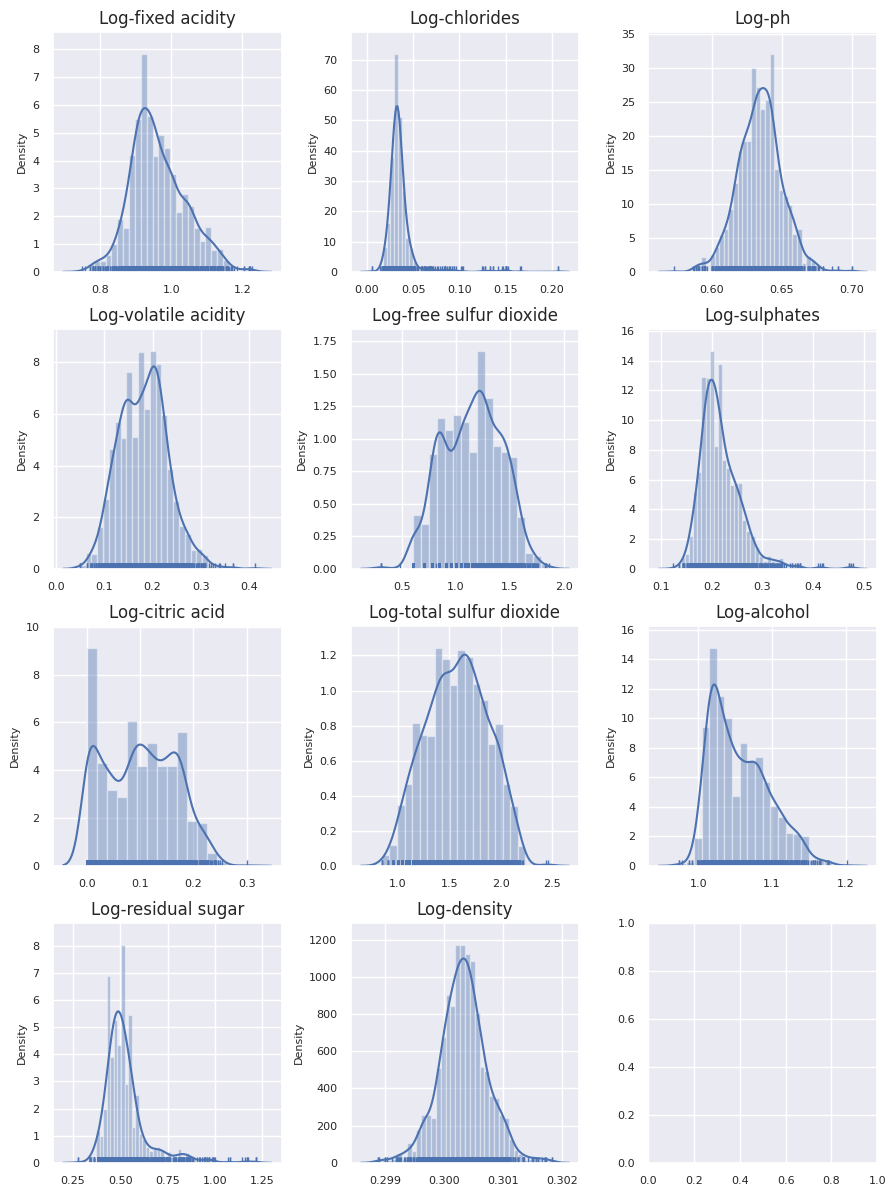

In [ ]:
wine_df_expanded = wine_df.copy(deep=True)

for column in wine_df.columns:
  if column != 'quality':
    name_new_col = 'log-%s'%column
    wine_df_expanded[name_new_col]=np.log10(wine_df[column].values + 1.0)
    #wine_df_expanded = wine_df_expanded.drop([column], axis=1)

print("\nRug Plots and Approximate Distribution of Each Variable\n")

fig, ax = plt.subplots(figsize=(9,12), nrows=4, ncols=3)
counter = 0
for column in wine_df_expanded.columns:
  print(column)
  if column.startswith('log-'):
    j = counter//4; i = counter%4;
    print(i,j)
    sns.distplot(wine_df_expanded[column].values,ax=ax[i,j],rug=True)
    ax[i,j].set_title(column.capitalize())
    counter += 1

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


In [ ]:
wine_df_multi_expanded = wine_df.copy(deep=True)
wine_df_multi_expanded['quality_multi'] = 0
wine_df_multi_expanded.loc[wine_df_expanded['quality'] <= 5, 'quality_multi'] = 0
wine_df_multi_expanded.loc[(wine_df_expanded['quality'] > 5) & (wine_df_expanded['quality'] <= 6), 'quality_multi'] = 1
wine_df_multi_expanded.loc[wine_df_expanded['quality'] >= 7, 'quality_multi'] = 2

X = wine_df_multi.drop(['quality','quality_multi'], axis=1).values
y = wine_df_multi['quality_multi'].values


rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

RANDOM STATE 22078


In [ ]:
from sklearn.svm import SVC
class_weights = dict()

print(X_train_scaled.shape)
svm = SVC(kernel='rbf',C=1)

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))

(1071, 11)
GLOBAL ACCURACY TRAIN SET (LIB) 0.7012138188608776
GLOBAL ACCURACY TEST SET (LIB) 0.6723484848484849

DETAILED REPORT TEST SET:

              precision    recall  f1-score   support

         bad       0.74      0.79      0.76       252
     average       0.59      0.65      0.62       207
        good       0.65      0.32      0.43        69

    accuracy                           0.67       528
   macro avg       0.66      0.59      0.60       528
weighted avg       0.67      0.67      0.66       528

